# Contents
- Preparing Data
- Creating a Simple Model
- Adding Augmentations
- Creating a Simple Neural Network
- Some black magic techniques...

We'll start by importing some dependencies:

In [22]:
import os
import gc
import re
import cv2
import sys
import glob
import keras

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style  as style

from tqdm  import tqdm
from keras import backend as K
from sklearn.svm import SVC
from sklearn.metrics     import accuracy_score, roc_auc_score
from keras.layers        import Dense, Dropout, Flatten, BatchNormalization, GlobalMaxPooling2D
from keras.models        import Sequential, Model, load_model
from keras.callbacks     import ModelCheckpoint,ReduceLROnPlateau, CSVLogger
from keras.activations   import elu
from keras.engine        import Layer, InputSpec
from keras.applications  import MobileNetV2
from keras.optimizers    import Adam
from keras.preprocessing import image
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenetv2 import preprocess_input, decode_predictions

In [3]:
# Disable SetCopyWarnings
pd.options.mode.chained_assignment = None

# Data Preparation

The first thing we'll do is index all the images we have from both datasets, we will use `glob` to accomplish this.

In [5]:
# Compose filenames
filelist_montgommery = glob.glob('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/*.png')
filelist_shenzen     = glob.glob('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/*.png')
filelist             = filelist_montgommery + filelist_shenzen

From the documentation, we know that the label is contained within the filename. To extract such label, we'll use the `re` module to implement regex to get the label. 

In [6]:
def extract_label(file_list):
    '''
    Label Extraction Function
    Reads a filename and extracts label from it
    '''
    labels = []
    for file in tqdm(file_list):
        current_label = re.findall('[0-9]{4}_(.+?).png', file)
        labels.append(current_label[0])
    return(labels)

In [7]:
labels = extract_label(filelist)

100%|██████████| 800/800 [00:00<00:00, 110901.75it/s]


Let's now transform our lists into a dataframe.

In [9]:
# Create dataframe
full_data = pd.DataFrame(filelist, columns=['filepath'])
full_data['target'] = labels
full_labels         = pd.DataFrame(full_data.pop('target'), columns=['target'])

# Preview dataframe
full_data.head()

,filepath
0,../input/pulmonary-chest-xray-abnormalities/Mo...
1,../input/pulmonary-chest-xray-abnormalities/Mo...
2,../input/pulmonary-chest-xray-abnormalities/Mo...
3,../input/pulmonary-chest-xray-abnormalities/Mo...
4,../input/pulmonary-chest-xray-abnormalities/Mo...


![](https://miro.medium.com/max/1552/1*Nv2NNALuokZEcV6hYEHdGA.png)

Now we have all the data into a single dataframe, but we need to split a certain amount for **model selection** (validation / probe) and for evaluating the model generalisation - the **testing set**.

In [11]:
# Split data into training and testing sets
train_df,test_df,train_y,test_y = train_test_split(full_data,
                                                   full_labels,
                                                   stratify     = full_labels,
                                                   test_size    = 0.3,
                                                   random_state = 451)

In [12]:
# Reassign labels so that we can split them again
train_df['target'] = train_y['target']
test_df['target']  = test_y['target']

In [13]:
# Split once more, so that we may produce a validation set
labels = train_df.pop('target')
train_df, probe_df, train_y, probe_y = train_test_split(train_df,
                                                        labels,
                                                        stratify     = labels,
                                                        test_size    = 0.2,
                                                        random_state = 451)

# Reassemble labels
train_df['target'] = train_y
probe_df['target'] = probe_y

# Exploratory Analysis

Now that we have our sets, let's have a look at them and check some images as well.

In [14]:
# Inspect Training Dataframe
train_df.head()

,filepath,target
255,../input/pulmonary-chest-xray-abnormalities/Ch...,0
232,../input/pulmonary-chest-xray-abnormalities/Ch...,0
694,../input/pulmonary-chest-xray-abnormalities/Ch...,0
712,../input/pulmonary-chest-xray-abnormalities/Ch...,0
379,../input/pulmonary-chest-xray-abnormalities/Ch...,1


In [15]:
def plot_multiple_images(image_dataframe, rows = 4, columns = 4, figsize = (16, 20), resize=(1024,1024), preprocessing=None):
    '''
    Plots Multiple Images
    Reads, resizes, applies preprocessing if desired and plots multiple images from a given dataframe
    '''
    image_dataframe = image_dataframe.reset_index(drop=True)
    fig = plt.figure(figsize=figsize)
    ax  = []

    for i in range(rows * columns):
        img = plt.imread(image_dataframe.loc[i,'filepath'])
        img = cv2.resize(img, resize)
        
        if preprocessing:
            img = preprocessing(img)
        
        ax.append(fig.add_subplot(rows, columns, i+1) )
        ax[-1].set_title("Xray "+str(i+1))
        plt.imshow(img, alpha=1, cmap='gray')
    
    plt.show()

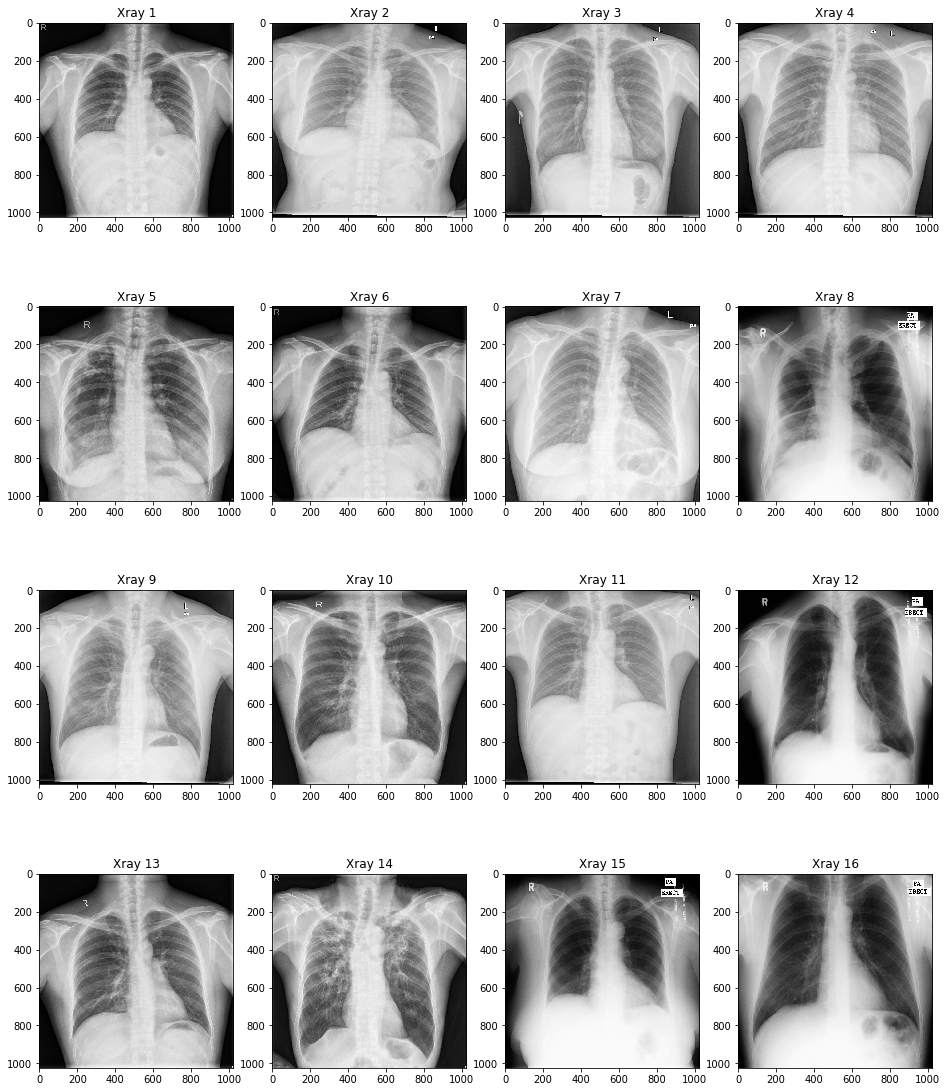

In [16]:
plot_multiple_images(train_df)

Instead of going for a fancy model, we'll start simple.
The most simple approach might be to just resize and flatten the pixels and send them to a simple model, such as a svm.

![](http://pwmpcnhis.bkt.clouddn.com/gitpage/deeplearning.ai/neural-networks-deep-learning/programming_assignments/week1_week2/2.png)

In [17]:
def load_image(image_path, image_dims = (128,128), grayscale=True, flatten=True, interpolation = cv2.INTER_AREA):
    '''
    Loads an image, resizes and removes redudant channels if so desired
    '''
    image         = cv2.imread(image_path)
    resized_image = cv2.resize(image, image_dims, interpolation = interpolation)
    
    if grayscale:
        resized_image = resized_image[:,:,0]
    
    if flatten:
        resized_image = resized_image.flatten()
    
    return(resized_image)

In [18]:
def create_flattened_dataframe(df, interpolation = cv2.INTER_AREA):
    df     = df.reset_index(drop=True)
    result = pd.DataFrame()
    
    for i in tqdm(range(df.shape[0])):
        im_path = df.loc[i,'filepath']
        current = load_image(im_path, interpolation = interpolation).tolist()
        current = pd.DataFrame(current).T
        result  = result.append(current)
    
    return(result)

In [19]:
# Flatten Training dataframe
train_df_flat = create_flattened_dataframe(train_df)
probe_df_flat = create_flattened_dataframe(probe_df)
test_df_flat  = create_flattened_dataframe(test_df)

100%|██████████| 240/240 [01:07<00:00,  2.88it/s]


In [20]:
train_df_flat.head()

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,19,18,17,17,17,16,17,16,16,16,...,28,28,28,28,28,29,30,31,67,108
0,60,35,34,33,31,30,27,25,23,23,...,164,161,160,170,170,170,175,180,181,141
0,101,62,64,63,62,58,56,53,50,46,...,100,101,106,111,112,113,120,124,127,131
0,31,27,25,24,24,23,22,23,22,21,...,75,73,73,79,77,77,79,81,81,64
0,20,20,21,20,20,20,20,20,20,20,...,44,26,3,4,6,7,7,9,67,68


With that, our flattened dataframe is ready to go and we can now create our model.

# Train using Support Vector Classifier (SVC), a type of SVM is used

We'll create a svm model, using `random state` for reproducibility .

In [23]:
# Define support vector classifier
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(train_df_flat, train_df['target'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

Our model is now ready, let us now create a function to evaluate the `Accuracy` and `AUC` of our model.

In [24]:
def evaluate_predictions(preds, eval_df = test_df):
    '''
    Evaluate Predictions Function
    Returns accuracy and auc of the model
    '''
    auroc = roc_auc_score(eval_df['target'].astype('uint8'), preds)
    accur = accuracy_score(eval_df['target'].astype('uint8'), preds >= 0.5)
    print('Accuracy: ' + str(auroc))
    print('AUC: ' + str(accur))

In [25]:
# Evaluate Model Results - Validation Set
svm_preds_val  = svm.predict_proba(probe_df_flat)
evaluate_predictions(svm_preds_val[:,1], eval_df = probe_df)

Accuracy: 0.8395534290271133
AUC: 0.7767857142857143


In [26]:
# Evaluate Model Results - Testing Set
svm_preds  = svm.predict_proba(test_df_flat)
evaluate_predictions(svm_preds[:,1], eval_df = test_df)

Accuracy: 0.8581550430675188
AUC: 0.7833333333333333




Our svm is doing quite well.


# Simple CNN - MobileNetV2

Notice that, for our last experiment, we loaded all images in memory and this is not ideal.
In the case of massive models, we usually create generators that will load a few instances of images each time, hence the idea of `batch_size`.

Our model, MobileNetV2 was created with the input size of 224x224, so we'll keep that in our model.

In [29]:
batch_size = 32
input_size = (224,224)

In order to help us load few images at a time, we'll use keras `ImageDataGenerator` - a class that allows us to load some images at a time using it's `flow` method and add data augmentation as well.

![](https://rock-it.pl/content/images/2017/05/doggs.jpg)

Data augmentation plays a major role in increasing the assertiveness of our models, especially when the dataset is rather small (as it is the case here).
Let's create a generator to do that.

In [30]:
# Create training data generator
train_generator = ImageDataGenerator(rescale = 1./255,
                                     horizontal_flip = True,
                                     zoom_range      = 0.1,
                                     shear_range     = 0,
                                     rotation_range  = 5,
                                     width_shift_range  = 0.05,
                                     height_shift_range = 0.05,
                                     fill_mode = 'constant',
                                     cval      = 0,
                                     preprocessing_function = preprocess_input)

# Create testing data generator
test_generator  = ImageDataGenerator(rescale = 1./255,
                                     preprocessing_function = preprocess_input)

Augmentation is one thing, but we also need to configure how the `ImageDataGenerator` will walk - or rather flow - through our dataset.

In [31]:
train = train_generator.flow_from_dataframe(dataframe = train_df,
                                    class_mode  = 'binary',
                                    x_col       = 'filepath',
                                    y_col       = 'target',
                                    shuffle     = True,
                                    batch_size  = batch_size,
                                    target_size = input_size,
                                    seed=451)

probe = train_generator.flow_from_dataframe(dataframe = probe_df,
                                    class_mode  = 'binary',
                                    x_col       = 'filepath',
                                    y_col       = 'target',
                                    shuffle     = True,
                                    batch_size  = batch_size,
                                    target_size = input_size,
                                    seed=451)

Found 448 validated image filenames belonging to 2 classes.
Found 112 validated image filenames belonging to 2 classes.


With that done, we can now build our neural network.

In [32]:
# Create model instance
model = Sequential()

# Add Pretrained Model
model.add(MobileNetV2(weights = 'imagenet', input_shape = (224,224,3), include_top=False))

# Add FC and Output layers
model.add(GlobalMaxPooling2D())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile Model
model.compile(optimizer=Adam(lr=1e-1), loss='binary_crossentropy', metrics=['acc'])
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                64050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 2,322,085
Trainable params: 2,287,973
Non-trainable params: 34,112
_________________________________________________________________


We can add support elements to our training, also known in keras as `callbacks`. They can help us manage our learning rate, create model checkpoints, use tensorboard and many more things.

For now we'll just use the `CSVLogger`, which save training logs a csv file.

In [33]:
# Create callback
csv_logger = CSVLogger('training_log_mobilenet_try_1.csv')

In [34]:
# Train model
model.fit_generator(
        train,
        callbacks = [csv_logger],
        epochs    = 10,
        steps_per_epoch  = train.samples // batch_size,
        validation_data  = probe,
        validation_steps = probe.samples // batch_size)

Epoch 1/10
14/14 [==============================] - 87s 6s/step - loss: 7.8983 - acc: 0.4933 - val_loss: 8.3033 - val_acc: 0.4792
Epoch 2/10
14/14 [==============================] - 57s 4s/step - loss: 8.0779 - acc: 0.4933 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/10
14/14 [==============================] - 58s 4s/step - loss: 8.0779 - acc: 0.4933 - val_loss: 8.7683 - val_acc: 0.4500
Epoch 4/10
14/14 [==============================] - 58s 4s/step - loss: 8.0779 - acc: 0.4933 - val_loss: 7.3734 - val_acc: 0.5375
Epoch 5/10
14/14 [==============================] - 59s 4s/step - loss: 8.0779 - acc: 0.4933 - val_loss: 8.4694 - val_acc: 0.4688
Epoch 6/10
14/14 [==============================] - 58s 4s/step - loss: 8.0779 - acc: 0.4933 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 7/10
14/14 [==============================] - 58s 4s/step - loss: 8.0779 - acc: 0.4933 - val_loss: 8.3698 - val_acc: 0.4750
Epoch 8/10
14/14 [==============================] - 59s 4s/step - loss: 8.0779 - acc: 0.49

This is rather strange, our model seems like garbage...let's see the performance on the testing set.

In [35]:
# Create test generator
test = test_generator.flow_from_dataframe(dataframe = test_df,
                                    class_mode  = 'binary',
                                    x_col       = 'filepath',
                                    y_col       = 'target',
                                    shuffle     = False,
                                    batch_size  = batch_size,
                                    target_size = input_size)

# Generate Predictions
preds = model.predict_generator(test, steps= test.samples / batch_size)

# Evaluate Model Results
evaluate_predictions(preds)

Found 240 validated image filenames belonging to 2 classes.
Accuracy: 0.5
AUC: 0.49166666666666664


Garbage confirmed!

Let's have a look at the training history

In [36]:
def plot_training_hist(keras_model):
    '''
    Plot training History
    Creates two plots of model training logs
    '''
    hist = keras_model.history.history
    style.use('fivethirtyeight')
    
    # Loss Plot
    fig = plt.figure(figsize=(12,4))
    plt.title('Loss Plot')
    plt.plot(hist['loss'], '#07e9ed')
    plt.plot(hist['val_loss'], '#0791ed')
    plt.ylim([0,1.2 * max(max(hist['loss'], hist['val_loss']))])
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    
    # Accuracy Plot
    fig = plt.figure(figsize=(12,4))
    plt.title('Accuracy Plot')
    plt.plot(hist['acc'], '#07e9ed')
    plt.plot(hist['val_acc'], '#0791ed')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.ylim([0,1])
    
    # Show Plot, reset style
    plt.show()
    style.use('default')

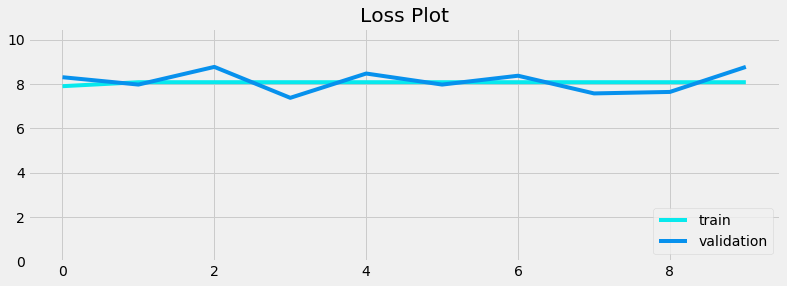

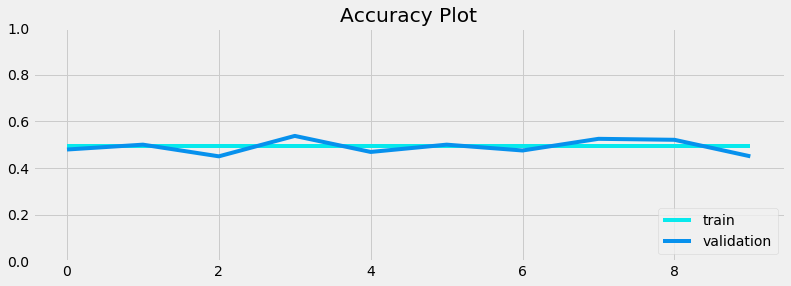

In [37]:
plot_training_hist(model)

Our network is way worse than our svm, how can that be?

In many ways this is a lesson in deep learning vs machine learning.

The idea that deep learning is superior is in many ways inadequate.
And the role of the human behind those models is often more important than the methods thenselves.


Deep learning often overshadows machine learning for it's capacity to accomplish many tasks.
While it certainly has some merit, other aproaches can also be just as good, sometimes better and frequently more `consistent`.


# Simple CNN - Trying Again

Now, let's make some small changes to our model.
We'll just lower the learning rate. Just that.

In [38]:
# Create model instance
model = Sequential()

# Add Pretrained Model
model.add(MobileNetV2(weights = 'imagenet', input_shape = (224,224,3), include_top=False))

# Add FC and Output layers
model.add(GlobalMaxPooling2D())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile Model
model.compile(optimizer=Adam(lr=2e-4), loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                64050     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 2,322,085
Trainable params: 2,287,973
Non-trainable params: 34,112
_________________________________________________________________


In [39]:
# Train model
model.fit_generator(
        train,
        callbacks = [csv_logger],
        epochs    = 15,
        steps_per_epoch  = train.samples // batch_size,
        validation_data  = probe,
        validation_steps = probe.samples // batch_size)

Epoch 1/15
14/14 [==============================] - 85s 6s/step - loss: 1.0502 - acc: 0.5893 - val_loss: 0.6060 - val_acc: 0.7000
Epoch 2/15
14/14 [==============================] - 59s 4s/step - loss: 0.6052 - acc: 0.6830 - val_loss: 0.4327 - val_acc: 0.7875
Epoch 3/15
14/14 [==============================] - 60s 4s/step - loss: 0.5618 - acc: 0.7277 - val_loss: 0.4633 - val_acc: 0.7750
Epoch 4/15
14/14 [==============================] - 62s 4s/step - loss: 0.5275 - acc: 0.7589 - val_loss: 0.4567 - val_acc: 0.8438
Epoch 5/15
14/14 [==============================] - 60s 4s/step - loss: 0.4786 - acc: 0.7746 - val_loss: 0.4985 - val_acc: 0.7875
Epoch 6/15
14/14 [==============================] - 61s 4s/step - loss: 0.5372 - acc: 0.7612 - val_loss: 0.4512 - val_acc: 0.7625
Epoch 7/15
14/14 [==============================] - 60s 4s/step - loss: 0.4502 - acc: 0.8080 - val_loss: 0.4277 - val_acc: 0.8250
Epoch 8/15
14/14 [==============================] - 61s 4s/step - loss: 0.4336 - acc: 0.78

In [40]:
# Create test generator
test = test_generator.flow_from_dataframe(dataframe = test_df,
                                    class_mode  = 'binary',
                                    x_col       = 'filepath',
                                    y_col       = 'target',
                                    shuffle     = False,
                                    batch_size  = batch_size,
                                    target_size = input_size)

# Generate Predictions
preds = model.predict_generator(test, steps= test.samples / batch_size)

# Evaluate Model Results
evaluate_predictions(preds)

Found 240 validated image filenames belonging to 2 classes.
Accuracy: 0.8977493748263405
AUC: 0.7708333333333334


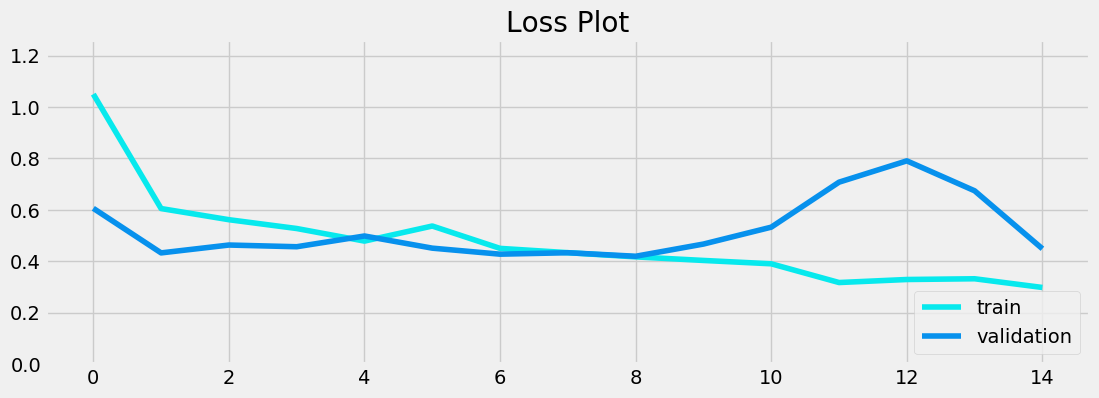

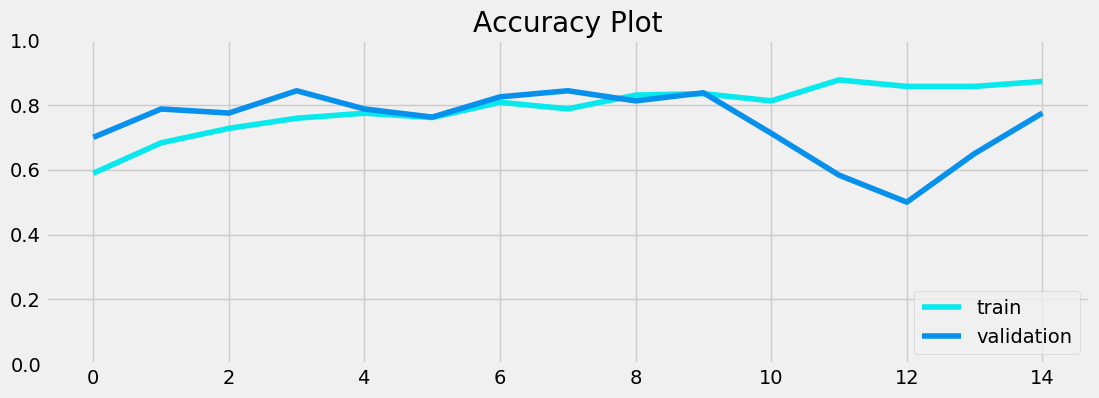

In [41]:
plot_training_hist(model)

Now that's far better, and we managed to improve our previous baseline score from the svm model.


In [43]:
# Save Model Weights as a File
model.save_weights('mobilenetv2_12sep.h5')

That concludes the core part of our workshop.
We created a simple model and used it as baseline to improve creating another simple CNN model.

From here on, we will dive into some neat tricks you can use.

# Viceroy Model

For now we are not allowed to use NN as our final deliverable, so let's dial down a bit.

However...we can use the convolutional layers to better interpret the information and then train a logistic regression on what the previous neural network 'saw'...

Let's try that...

In [44]:
# Create function to extract bottlenet features
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(index=1).output)

# Create training dataset using bottleneck features
intermediate_output = intermediate_layer_model.predict_generator(test_generator.flow_from_dataframe(dataframe = train_df,
                                    class_mode  = 'binary',
                                    x_col       = 'filepath',
                                    y_col       = 'target',
                                    shuffle     = False,
                                    batch_size  = batch_size,
                                    target_size = input_size,
                                    seed        = 451), steps = train_df.shape[0] / batch_size)

intermediate_output_df = pd.DataFrame(intermediate_output)
intermediate_output_df.head()

# Create bottleneck features dataset for testing set
intermediate_output_df_test = pd.DataFrame(intermediate_layer_model.predict_generator(test_generator.flow_from_dataframe(dataframe = test_df,
                                    class_mode  = 'binary',
                                    x_col       = 'filepath',
                                    y_col       = 'target',
                                    shuffle     = False,
                                    batch_size  = batch_size,
                                    target_size = input_size,
                                    seed        = 451), steps = test_df.shape[0] / batch_size))

Found 448 validated image filenames belonging to 2 classes.
Found 240 validated image filenames belonging to 2 classes.


In [45]:
# Our new model
viceroy_logreg = LogisticRegression(multi_class='auto', solver='lbfgs', random_state=451, max_iter=1000)
viceroy_logreg.fit(intermediate_output_df, train_y)

# Evaluate Model Results
viceroy_logit_preds  = viceroy_logreg.predict_proba(intermediate_output_df_test)
evaluate_predictions(viceroy_logit_preds[:,1])

Accuracy: 0.8946235065295916
AUC: 0.8083333333333333


# Performing Test Time Augmentation

We can use augmentation to improve the training of neural nets.

We can also use it to 

In [46]:
def TTA_wraper(dl_model, df = test_df, steps = 10, bs = batch_size, sz = input_size, seed = 451):
    # Taken from: https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d
    tta_steps   = steps
    predictions = []

    for i in tqdm(range(tta_steps)):
        tta_pred = dl_model.predict_generator(train_generator.flow_from_dataframe(dataframe = df,
                                        class_mode  = 'binary',
                                        x_col       = 'filepath',
                                        y_col       = 'target',
                                        shuffle     = False,
                                        batch_size  = bs,
                                        target_size = sz,
                                        seed        = seed * i), steps = df.shape[0] / batch_size)
        predictions.append(tta_pred)

    tta_preds = np.mean(predictions, axis=0)
    return(tta_preds)

In [47]:
tta_preds = TTA_wraper(model)
evaluate_predictions(tta_preds)

  0%|          | 0/10 [00:00<?, ?it/s]

Found 240 validated image filenames belonging to 2 classes.


 10%|█         | 1/10 [00:27<04:11, 27.95s/it]

Found 240 validated image filenames belonging to 2 classes.


 20%|██        | 2/10 [00:58<03:50, 28.75s/it]

Found 240 validated image filenames belonging to 2 classes.


 30%|███       | 3/10 [01:28<03:23, 29.01s/it]

Found 240 validated image filenames belonging to 2 classes.


 40%|████      | 4/10 [01:57<02:55, 29.21s/it]

Found 240 validated image filenames belonging to 2 classes.


 50%|█████     | 5/10 [02:27<02:26, 29.31s/it]

Found 240 validated image filenames belonging to 2 classes.


 60%|██████    | 6/10 [02:56<01:57, 29.32s/it]

Found 240 validated image filenames belonging to 2 classes.


 70%|███████   | 7/10 [03:25<01:27, 29.24s/it]

Found 240 validated image filenames belonging to 2 classes.


 80%|████████  | 8/10 [03:55<00:58, 29.38s/it]

Found 240 validated image filenames belonging to 2 classes.


 90%|█████████ | 9/10 [04:24<00:29, 29.41s/it]

Found 240 validated image filenames belonging to 2 classes.


100%|██████████| 10/10 [04:56<00:00, 29.97s/it]

Accuracy: 0.9357460405668241
AUC: 0.85
